###This document has been adapted for the Harvard tinyML course from the Arduino gesture regonition tutorial.



##Credit
Tiny ML on Arduino: Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions

 
https://github.com/arduino/AIoT-Dev-Summit-2019

## Setup Python Environment 

Install up the Python libraries and Linux tools for the code in the notebook.

In [4]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
%tensorflow_version 2.x
!pip install tensorflow

# Upload Data

1. Navigat to the folders tab on the left
2. Upload the .csv files from the gestures/ folder of the assignment repo

# Graphing Data

The following code visualizes a one second sample of the accelerometer and gyroscope input which is captured at 119 Hz. This is an example of the data that will be passed to the neural network.

Change the filename from handwash.csv to other.csv. If you were given these samples to classify, what patterns would you look for?



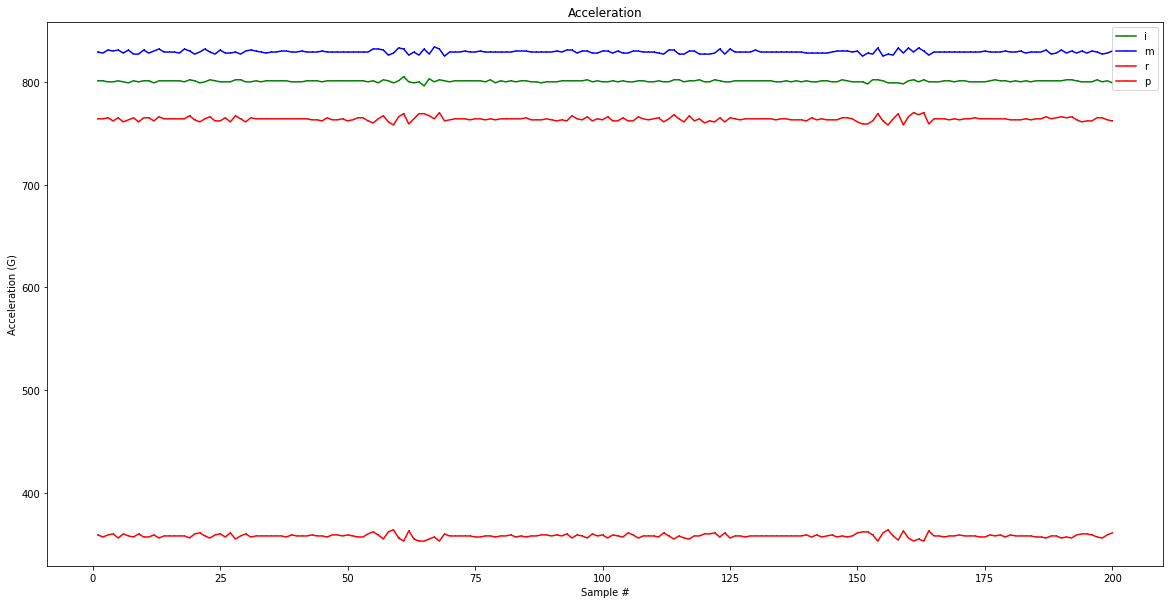

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "a.csv"

SAMPLES_PER_GESTURE = 200

df = pd.read_csv("/content/" + filename)

index = range(1, SAMPLES_PER_GESTURE+1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['index'][:SAMPLES_PER_GESTURE], 'g.', label='i', linestyle='solid', marker=',')
plt.plot(index, df['middle'][:SAMPLES_PER_GESTURE], 'b.', label='m', linestyle='solid', marker=',')
plt.plot(index, df['ring'][:SAMPLES_PER_GESTURE], 'r.', label='r', linestyle='solid', marker=',')
plt.plot(index, df['pinky'][:SAMPLES_PER_GESTURE], 'r.', label='p', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

# plt.plot(index, df['gX'][:SAMPLES_PER_GESTURE], 'g.', label='x', linestyle='solid', marker=',')
# plt.plot(index, df['gY'][:SAMPLES_PER_GESTURE], 'b.', label='y', linestyle='solid', marker=',')
# plt.plot(index, df['gZ'][:SAMPLES_PER_GESTURE], 'r.', label='z', linestyle='solid', marker=',')
# plt.title("Gyroscope")
# plt.xlabel("Sample #")
# plt.ylabel("Gyroscope (deg/sec)")
# plt.legend()
# plt.show()


# Train Neural Network





## Parse and prepare the data

Parse the CSV files and transforms them to a format that can be used to train the neural network.

**Take note** that the input data is formatted differently for the CNN. Instead of one long input vector, the input is formatted as such: 119 measurements (height), 3 axes (width) and, 2 sensors (channels). This is important in understanding how the CNN operates.




In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures 
GESTURES = [
    "a",
    "am",
    "b",
    "bm",
    "c",
    "cm",
    "d",
    "dm",
    "e",
    "em",
    "f",
    "g",
    "gm"
]

SAMPLES_PER_GESTURE = 200

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []
min_num = 99999
max_num = -999999
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  df = pd.read_csv("/content/" + gesture + ".csv")
  df = df.dropna()
  df = df.reset_index(drop=True)
  min_num = min(min_num, int(min(df['index'])), min(df['middle']), min(df['ring']), min(df['pinky']))
  max_num = max(max_num, int(max(df['index'])), max(df['middle']), max(df['ring']), max(df['pinky']))

print("Min number is ", min_num)
print("Max number is ", max_num)

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/" + gesture + ".csv")

  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  #Format the input data
  #For the input into this CNN the inputs must be formatted as [119][3][2]
  #The inner dimensions ([3][2]) are somewhat arbitrary but used in this order
  #to be consistent with the example from the tinyML book
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor.append([[
          (float(df['index'][index]) - min_num) / (max_num - min_num)
      ],
      [
           (df['middle'][index] - min_num) / (max_num - min_num)
      ],
      [
          (df['ring'][index] - min_num) / (max_num - min_num)
      ],
      [
           (df['pinky'][index] - min_num) / (max_num - min_num)
      ]])

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.3.0

Min number is  308.0
Max number is  904
Processing index 0 for gesture 'a'.
	There are 105 recordings of the a gesture.
Processing index 1 for gesture 'am'.
	There are 208 recordings of the am gesture.
Processing index 2 for gesture 'b'.
	There are 113 recordings of the b gesture.
Processing index 3 for gesture 'bm'.
	There are 140 recordings of the bm gesture.
Processing index 4 for gesture 'c'.
	There are 135 recordings of the c gesture.
Processing index 5 for gesture 'cm'.
	There are 362 recordings of the cm gesture.
Processing index 6 for gesture 'd'.
	There are 115 recordings of the d gesture.
Processing index 7 for gesture 'dm'.
	There are 124 recordings of the dm gesture.
Processing index 8 for gesture 'e'.
	There are 136 recordings of the e gesture.
Processing index 9 for gesture 'em'.
	There are 108 recordings of the em gesture.
Processing index 10 for gesture 'f'.
	There are 103 recordings of the f gesture.
Processing index 11 for gesture 'g'.
	The

## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [10]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.


**Take Note** Our model is now a small CNN with two convolution layers that create "learned features" that are then passed to two dense layers that produce a classification.

The input shape must be specified for the first Conv2D layer.

In [16]:
# build the model and train it
model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          8, (1, 3),
          padding="same",
          activation="relu",
          # input_shape=(SAMPLES_PER_GESTURE, 3, 2)),  # output_shape=(batch, 128, 3, 8)
          input_shape=(SAMPLES_PER_GESTURE, 4, 1)),
      tf.keras.layers.MaxPool2D((3, 3)),  # (batch, 42, 1, 8)
      tf.keras.layers.Dropout(0.1),  # (batch, 42, 1, 8)
      tf.keras.layers.Conv2D(16, (1, 3), padding="same",
                             activation="relu"),  # (batch, 42, 1, 16)
      tf.keras.layers.MaxPool2D((3, 1), padding="same"),  # (batch, 14, 1, 16)
      tf.keras.layers.Dropout(0.1),  # (batch, 14, 1, 16)
      tf.keras.layers.Flatten(),  # (batch, 224)
      tf.keras.layers.Dense(16, activation="relu"),  # (batch, 16)
      tf.keras.layers.Dropout(0.1),  # (batch, 16)
      tf.keras.layers.Dense(13, activation="softmax")  # (batch, 4)
  ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/600
1109/1109 [==============================] - 2s 2ms/step - loss: 2.0237 - mae: 0.1261 - accuracy: 0.3048 - val_loss: 1.3022 - val_mae: 0.1051 - val_accuracy: 0.4960
Epoch 2/600
1109/1109 [==============================] - 2s 2ms/step - loss: 1.0692 - mae: 0.0889 - accuracy: 0.5744 - val_loss: 0.7079 - val_mae: 0.0692 - val_accuracy: 0.7305
Epoch 3/600
1109/1109 [==============================] - 2s 2ms/step - loss: 0.7499 - mae: 0.0667 - accuracy: 0.6889 - val_loss: 0.5650 - val_mae: 0.0576 - val_accuracy: 0.8356
Epoch 4/600
1109/1109 [==============================] - 2s 2ms/step - loss: 0.6172 - mae: 0.0565 - accuracy: 0.7475 - val_loss: 0.5100 - val_mae: 0.0497 - val_accuracy: 0.7817
Epoch 5/600
1109/1109 [==============================] - 2s 2ms/step - loss: 0.5682 - mae: 0.0523 - accuracy: 0.7529 - val_loss: 0.4926 - val_mae: 0.0466 - val_accuracy: 0.8005
Epoch 6/600
1109/1109 [==============================] - 2s 2ms/step - loss: 0.5275 - mae: 0.0493 - accuracy: 0.763

## Verify 

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

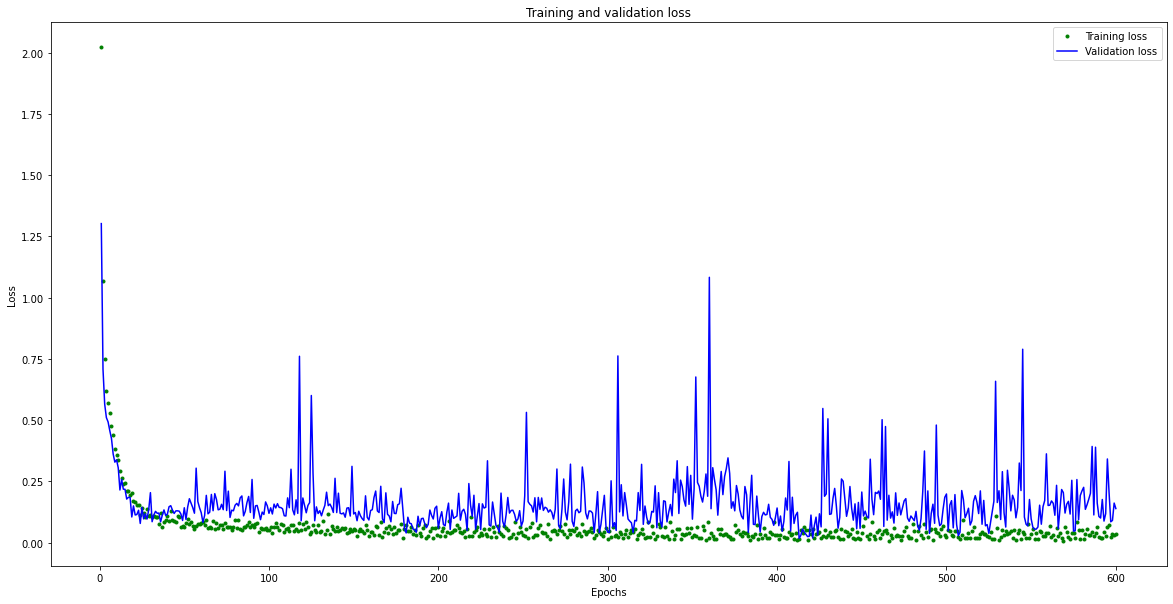

[20.0, 10.0]


In [17]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

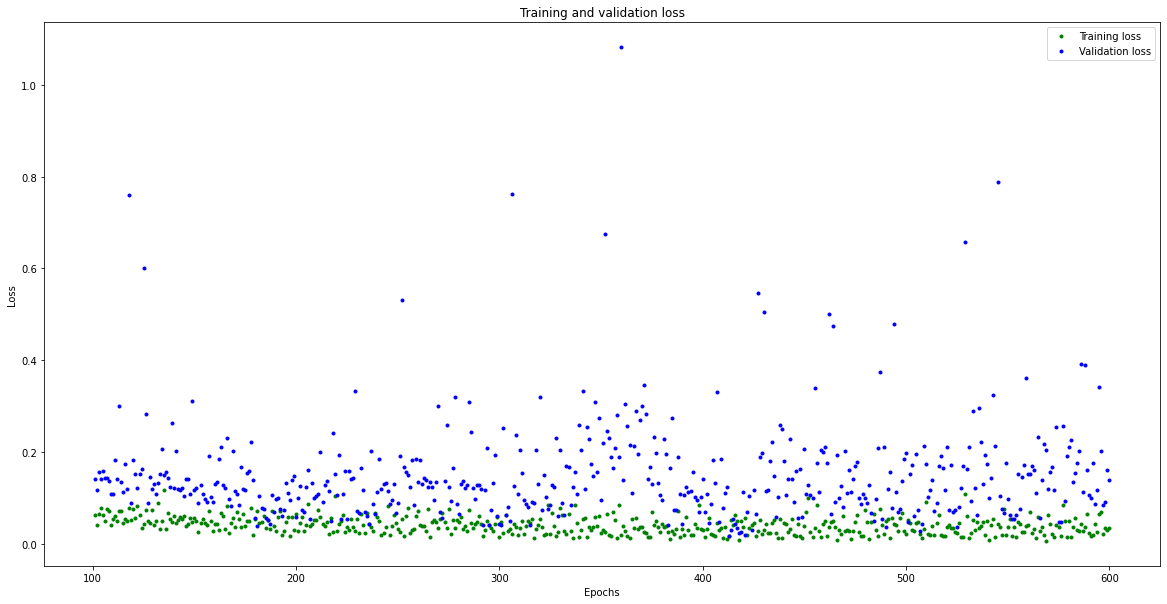

In [18]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



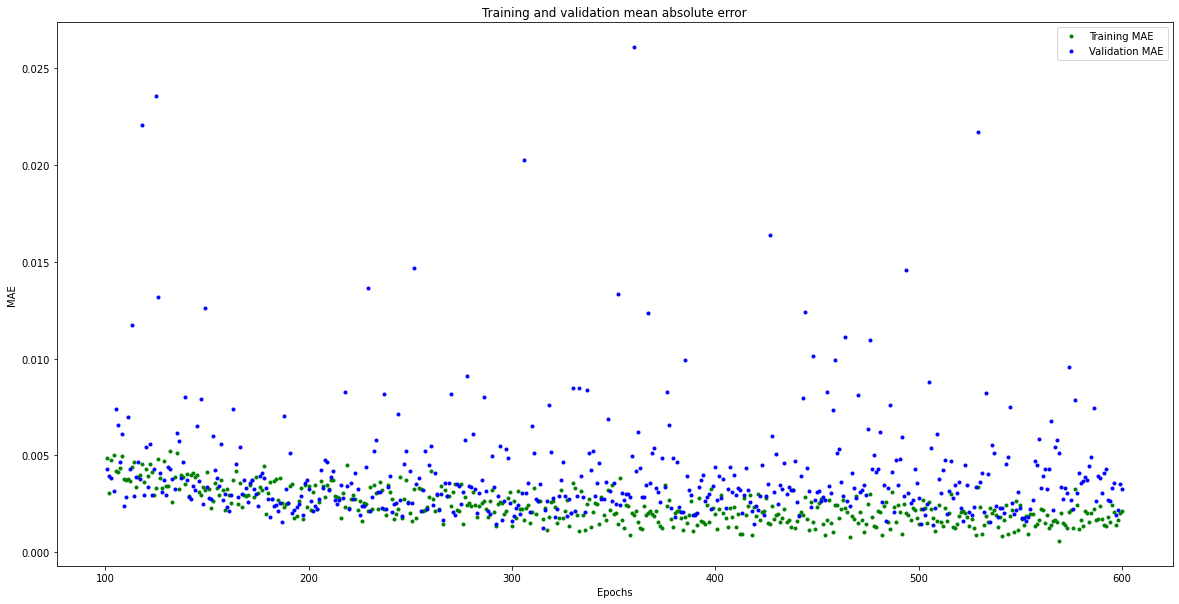

In [19]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### Run with Test Data
Put our test data into the model and compare the predictions vs actual output

*The confusion matrix* is a useful tool for understanding misclassifications.

The columns represent the labels predicted by the model and the rows represent the groud truth labels.

This can be a great tool to understand the balence and fairness of your model. For example, if a column has only zeros then the model is never guessing that label.

**Take Note** You will submit the entire output of this cell

Training accuracy:  0.9864742755889893
Validation accuracy:  0.9784366488456726


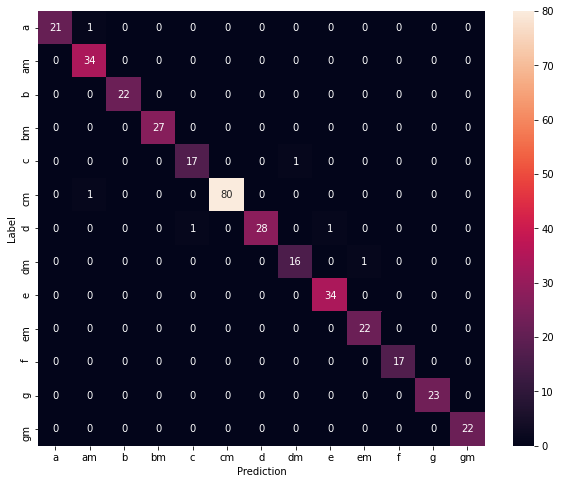

In [20]:
import seaborn as sns

# use the model to predict the test inputs
predictions = model.predict(inputs_test)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print('Training accuracy: ', acc[-1])
print('Validation accuracy: ', val_acc[-1])


def index_of_max(output_list):
  #takes a list of list
  #returns a list of the index of the max of the sub lists
  list_of_indicies = []
  for sub_list in output_list:
    list_of_indicies.append(np.argmax(sub_list))
  return list_of_indicies

confusion = tf.math.confusion_matrix(
    labels=tf.constant(index_of_max(outputs_test)),
    predictions=tf.constant(index_of_max(predictions)),
    num_classes=NUM_GESTURES)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, xticklabels=GESTURES, yticklabels=GESTURES, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. 

The size of the model is printed out in bytes. How does the size of this model compare to the FC model?

**TAKE NOTE** You will have to submit the model size

In [21]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpk8nsnrt9/assets
Model is 28292 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [22]:
!apt-get update
!apt-get -qq install xxd


!echo "const unsigned char model[] __attribute__((aligned(4))) = {"  > /content/model.h
!cat gesture_model.tflite | xxd -i                                  >> /content/model.h
!echo "};"                                                          >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [40.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:13 https://developer.download.nvi

# Classifying IMU Data

Now it's time to switch back to the instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.
